# Engesgaard and Kipp 1992

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#add mf6rtm path to the system
sys.path.insert(0,os.path.join("..","..","mf6rtm"))
import flopy
import mf6rtm
import utils

prefix = 'engesgaard1992'
DT_FMT = "%Y-%m-%d %H:%M:%S"

# Model Constants

In [2]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

nper = 1  # Number of periods
nlay = 1  # Number of layers
Lx = 0.5 #m
ncol = 50 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 0.  # Top of the model ($m$)
botm = -1.0  # Layer bottom elevations ($m$)
prsity = 0.32  # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)

tstep = 0.01  # Time step ($days$)
perlen = 0.24  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp

chdspd = [[(0, 0, ncol - 1), 1.]]  # Constant head boundary $m$
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, 0, :] = 1  # Starting head ($m$)

tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

icelltype = 1  # Cell conversion type
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[0, 0, -1] = -1

q=0.259 #m3/d

wel_spd = [[(0,0,0), q]]

#transport
dispersivity = 0.0067 # Longitudinal dispersivity ($m$)

# Set solver parameter values (and related)
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
ttsmult = 1.0
dceps = 1.0e-5  # HMOC parameters in case they are invoked
nplane = 1  # HMOC
npl = 0  # HMOC
nph = 4  # HMOC
npmin = 0  # HMOC
npmax = 8  # HMOC
nlsink = nplane  # HMOC
npsink = nph  # HMOC

## Initialize Chemistry

In [3]:
dataws = os.path.join("..", "data")

files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)

#get postfix file
postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
solutionsdf

,sol_bck,sol_in
comp,,
pH,9.910000,7.000
pe,4.000000,4.000
C(+4),0.000123,0.000
Ca,0.000123,0.000
Cl,0.000000,0.002
Mg,0.000000,0.001


In [4]:
# get equilibrium phases file
equilibrium_phases = utils.equilibrium_phases_csv_to_dict(os.path.join(dataws, f'{prefix}_equilibrium_phases.csv'))
equilibrium_phases

{1: {'Calcite': [0.0, 0.0001220625], 'Dolomite': [0.0, 0.0]}}

In [5]:
#assign solutions to grid
# sol_ic = np.ones(ncol)
sol_ic = 1

#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

#create equilibrium phases class
equilibrium_phases = mf6rtm.EquilibriumPhases(equilibrium_phases)
equilibrium_phases.set_ic(1)

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}_mf6rtm'))

#set database
database = os.path.join('..', 'database', f'pht3d_datab.dat')
model.set_database(database)

#include equilibrium phases in model class
model.set_equilibrium_phases(equilibrium_phases)

#get phreeqc input
phinp = model.generate_phreeqc_script(postfix =  postfix)

In [6]:
#initialize model
model.initialize()

Phreeqc initialized


In [7]:
wellchem = mf6rtm.ChemStress('wel')

sol_spd = [2]

wellchem.set_spd(sol_spd)

In [8]:
wellchem.sol_spd

[2]

In [9]:
model.set_chem_stress(wellchem)


Initializing ChemStress
ChemStress wel initialized


In [10]:
model.wel.data
model.wel.auxiliary

['H', 'O', 'Charge', 'C', 'Ca', 'Cl', 'Mg']

In [11]:
model.components

['H', 'O', 'Charge', 'C', 'Ca', 'Cl', 'Mg']

# Build model

In [12]:
def build_model(model):
    ##################### GWF model #####################

    gwfname = 'gwf'
    sim_ws = model.wd
    sim = flopy.mf6.MFSimulation(sim_name=model.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # if init_comp == None:
    #     auxiliary = 'tracer'
    # else:
    #     auxiliary = [c for c in init_comp]

    # if wel_rec == None:
    #     cin = 1.0e-3
    #     cin = concentration_l_to_m3(cin)
    #     wel_rec = spd = [[(0,0,0), 0.259, cin]]
    for i in range(len(wel_spd)):
        wel_spd[i].extend(model.wel.data[i])
    print(wel_spd)

    wel = flopy.mf6.ModflowGwfwel(
            gwf,
            stress_period_data=wel_spd,
            save_flows = True,
            auxiliary = model.components,
            pname = 'wel',
            filename=f"{gwfname}.wel"
        )
    wel.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in model.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=model.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()

        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['wel', 'aux', f'{c}']
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        alpha_th = np.ones(shape=(nlay, nrow, ncol))*1  # Transverse horizontal dispersivity ($m$)
        alpha_tv = np.ones(shape=(nlay, nrow, ncol))*1  # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=alpha_th,
            atv = alpha_tv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None


        # print('--- Building SRC package ---')
        # src_spd = src_array(q, init_comp, c)
        # src = flopy.mf6.ModflowGwtsrc(
        #     gwt,
        #     stress_period_data = src_spd,
        #     save_flows = True,
        #     filename=f"{gwtname}.src"
        # )
        # src.set_all_data_external()

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        # ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "LAST"), 
                            # ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [13]:
sim = build_model(model)

[[(0, 0, 0), 0.259, 110684.17118025024, 55342.08560564268, -3.103509931539338e-05, 0.0, 0.0, 1.994086023627226, 0.9970430118137076]]
Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: C
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Ca
--- Building I

In [14]:
dll = os.path.join(model.wd,"libmf6")
dll


'engesgaard1992_mf6rtm\\libmf6'

In [15]:
model.set_charge_offset(0.0)

In [16]:
model.init_conc_array_phreeqc

array([1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 1.10684337e+02, 1.10684337e+02,
       1.10684337e+02, 1.10684337e+02, 5.53425357e+01, 5.53425357e+01,
       5.53425357e+01, 5.53425357e+01, 5.53425357e+01, 5.53425357e+01,
      

In [17]:
model.run_mup3d(sim)


-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, C, Ca, Cl, Mg
Starting transport solution at 2024-05-31 08:42:52

Getting concentration arrays --- time step: 1 --- elapsed time: 0.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Mg

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took  0.0004669 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 7 iters --- took 0.00052537 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport st

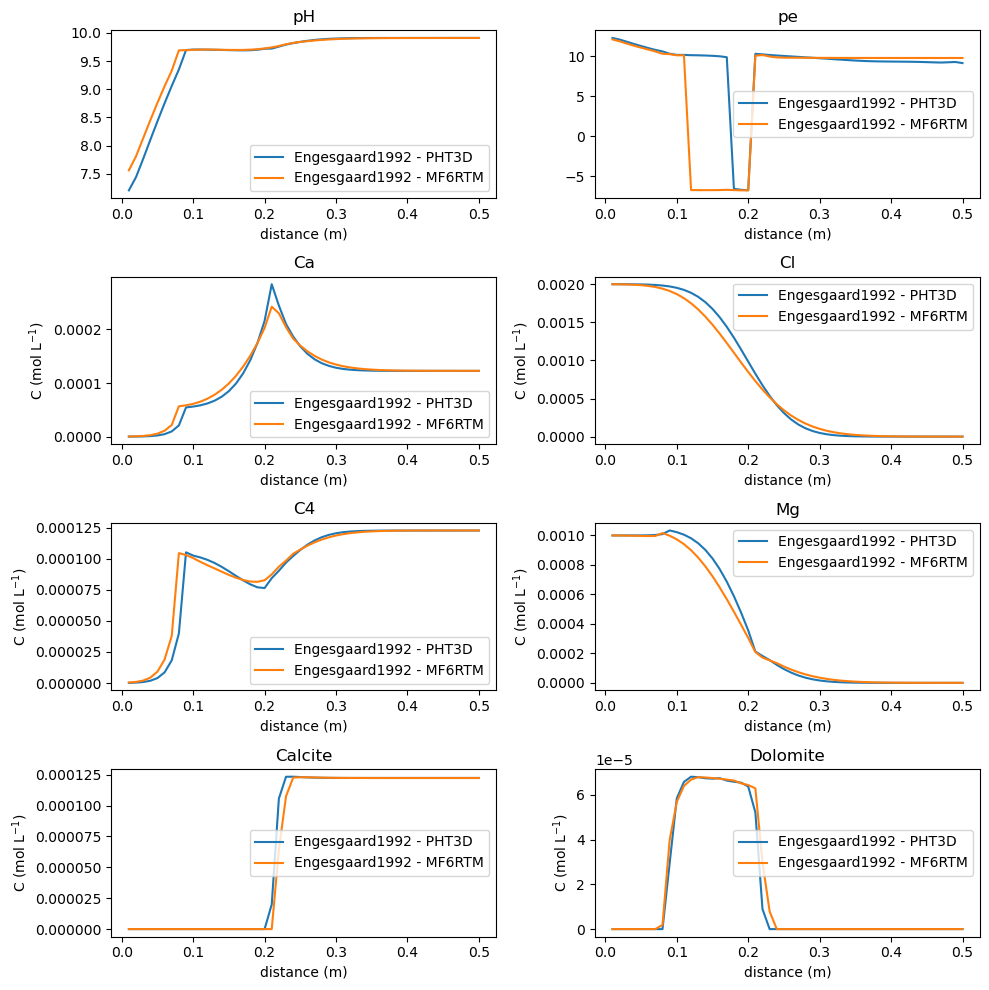

In [18]:
wd = os.path.join('engesgaard1992_pht3d')
dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * dx 
simdf.drop(columns = 'H', inplace = True)

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr
simapi = simapi[simdf.columns]

simapi

fig, axs = plt.subplots(4,2, figsize = (10, 10))


for var, ax in zip(simapi.iloc[:,1:-1 ].columns, axs.flatten()):
    ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    ax.plot(simapi.x.unique(), simapi.loc[simapi.index.unique()[-1], var], label = 'Engesgaard1992 - MF6RTM')
    ax.set_xlabel('distance (m)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-1}$)')
    ax.set_title(f'{var}')
    ax.legend()
fig.tight_layout()